In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [ ]:
!pwd

/content


In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DBUILD_PYTHON=ON .. && make -j`nproc`
!mkdir openpose/images openpose/videos 

Selecting previously unselected package libgflags2.2.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

In [ ]:
!pwd
%cd /content

/content
/content


In [ ]:
def classification_model():
  return tf.keras.models.load_model('/content/drive/MyDrive/LG/classification2.h5', compile=False)

In [ ]:
def preprocess(img_path):
  img = load_img(img_path,target_size=(640,640))
  img_array = img_to_array(img)
  img_array = img_array/255
  img_batch = np.expand_dims(img_array, axis=0)
  return img_batch

In [ ]:
!pwd

/content


In [ ]:

def label_img(opWrapper, img):
    datum = op.Datum()
    datum.cvInputData = img
    opWrapper.emplaceAndPop(op.VectorDatum([datum]))
    return datum

def scale_transform(coords):
    """
    Parameters:
    coords (25x3 ndarray): array of (x,y,c) coordinates
    Returns:
    ndarray: coords scaled to 1x1 with center at (0,0)
    ndarray: confidence scores of each joint
    """
    coords, scores = coords[:, :, :-1], coords[:, :, -1]
    diff = coords.max(axis=1) - coords.min(axis=1)
    diff_max = np.max(diff, axis=0)
    mean = coords.mean(axis=1).reshape(
                coords.shape[0],
                1,
                coords.shape[-1]
    )
    out = (coords - mean) / diff_max

    return out, scores

def make_vector(poseKeypoints):
    """
    Parameters:
    poseKeypoints (ndarray): Single person output from OpenPose
    Returns:
    ndarray: scaled, transformed, normalized row vector
    """
    N, D, C = poseKeypoints.shape
    coords, pose_scores = scale_transform(poseKeypoints)
    pose_scores = pose_scores.reshape((N, D, 1))
    coords_vec = np.concatenate([coords, pose_scores], axis=2)
    coords_vec /= np.linalg.norm(coords_vec, axis=2)[:, :, np.newaxis]
    return coords_vec

In [ ]:
#['Triangle', 'cobra', 'downdog', 'goddess', 'plank', 'tree', 'warrior2']

In [ ]:
# from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
# model = tf.keras.models.Sequential([
#     Dense(128, input_shape=(150,)),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(128),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(1),
#     BatchNormalization(),
#     Activation('sigmoid'),
# ])

# model.load_weights('/content/drive/MyDrive/LG/train_log/ckpt_99')

In [ ]:
# model.save('/content/drive/MyDrive/LG/comparator_net.h5')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.callbacks import CSVLogger

In [ ]:
model = Sequential([
    Dense(128, input_shape=(150,)),
    BatchNormalization(),
    Activation('relu'),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(1),
    BatchNormalization(),
    Activation('sigmoid'),
])

In [ ]:
model.load_weights('/content/drive/MyDrive/LG/train_log_2/ckpt_6')

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [1.77596451e+02 1.26481354e+02 1.65408552e-01]
  [2.09919128e+02 1.28207977e+02 1.22844577e-01]
  [2.09883774e+02 1.17978134e+02 1.76920831e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [1.43541275e+02 1.29871460e+02 4.80583221e-01]
  [8.91375198e+01 1.35000336e+02 8.11692774e-01]
  [1.04384430e+02 8.74034500e+01 8.68185401e-01]
  [1.70848434e+02 1.02647827e+02 4.04452473e-01]
  [1.79281601e+02 9.07351379e+01 3.43926668e-01]
  [1.55396149e+02 3.79581528e+01 4.80347931e-01]
  [1.40139618e+02 3.29019356e+01 3.33437145e-01]
  [1.67365585e+02 1.16298103e+02 3.50315183e-01]
  [1.57131592e+02 4.98763657e+01 1.01651929e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.

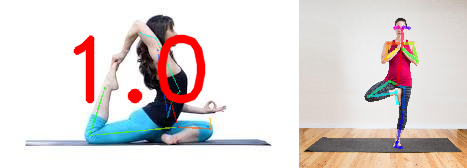

In [ ]:
import sys
import cv2
OpenposeDir = '/content/openpose/'
pyopenpose_dir = os.path.join(OpenposeDir,'build','python') # ex: '/content/openpose/build/python'
if pyopenpose_dir not in sys.path:
    sys.path.append(pyopenpose_dir)
from openpose import pyopenpose as op
from google.colab.patches import cv2_imshow

params = dict()
params['model_folder'] = 'openpose/models/'
params['net_resolution'] = '176x176'
params['number_people_max'] = 1
params['display'] = 0
params['disable_multi_thread'] = True
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()


dir = '/content/drive/MyDrive/LG/test'
out_dir = '/content/drive/MyDrive/LG/test2_out_original/'
for image in os.listdir(dir):
  user_img_path = dir +'/'+ image
  #print(image)
  clsf_model = classification_model()
  #user_img_path='/content/drive/MyDrive/LG/fine/cobra2/00000001.jpeg'
  user_img = preprocess(user_img_path)
  result = clsf_model.predict(user_img)
  pose_class = np.argmax(result)
  #print(pose_class)

  user_raw_img = user_img_path
  ideal_raw_img = '/content/drive/MyDrive/LG/Ideal/'+str(pose_class)+'.jpeg'

  user_img = cv2.imread(user_raw_img)
  ideal_img = cv2.imread(ideal_raw_img)

  #user_img = cv2.resize(user_img,(700,400))
  #ideal_img = cv2.resize(ideal_img,(700,400))


  user_datum = label_img(opWrapper, user_img)
  target_datum = label_img(opWrapper, ideal_img)
  print(user_datum)
  
  #comparator_model = tf.keras.models.load_model('/content/drive/MyDrive/LG/comparator_net.h5', compile=False)
  comparator_model = tf.keras.models.load_model('/content/drive/MyDrive/LG/comparator_net.h5')
  #comparator_model = model
  if type(user_datum.poseKeypoints) == np.ndarray and user_datum.poseKeypoints.shape == (1, 25, 3):
    if type(target_datum.poseKeypoints) == np.ndarray or target_datum.poseKeypoints.shape == (1, 25, 3):
      coords_vec = make_vector(user_datum.poseKeypoints)
      target_coords_vec = make_vector(target_datum.poseKeypoints)
      input_vec = np.concatenate([coords_vec, target_coords_vec]).flatten()
      similarity_score = comparator_model.predict(input_vec.reshape((1, -1)))
  #print(similarity_score)
  #screen_out = np.concatenate((user_datum.cvOutputData,target_datum.cvOutputData),axis=1)
  def hconcat_resize(img_list, 
                   interpolation 
                   = cv2.INTER_CUBIC):
      # take minimum hights
    h_min = min(img.shape[0] 
                for img in img_list)
      
    # image resizing 
    im_list_resize = [cv2.resize(img,
                       (int(img.shape[1] * h_min / img.shape[0]),
                        h_min), interpolation
                                 = interpolation) 
                      for img in img_list]
    # return final image
    return cv2.hconcat(im_list_resize)
  # function calling
  img_h_resize = hconcat_resize([user_datum.cvOutputData, target_datum.cvOutputData])
  
  g = float("{:.2f}".format(similarity_score[0][0]))
  font = cv2.FONT_HERSHEY_DUPLEX
  cv2.putText(img_h_resize, ' ' + str(g), (10, 100), font, 3, (0, 0, 255), 3, cv2.LINE_AA)
  cv2_imshow(img_h_resize)
  #cv2_imshow(user_datum.cvOutputData)
  #cv2_imshow(target_datum.cvOutputData)
  #print(g)
  #image = image.split('.')[0] + '.jpeg'
  #cv2.imwrite(out_dir+image, screen_out)
  break